# Forecasting Prediction Using Exponential Smoothing

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/train.csv')

In [3]:
data_1_1 = data[data['store'] == 1]
data_1_1 = data_1_1[data_1_1['item'] == 1]
data_1_1 = data_1_1[['date','sales']]
data_1_1 = data_1_1.set_index('date')

In [4]:
first_diff = data_1_1.sales - data_1_1.sales.shift(1)
first_diff = first_diff.dropna()

In [5]:
cutoff_date = '2017-10-01'

train = first_diff.loc[first_diff.index < cutoff_date]
test = first_diff.loc[first_diff.index >= cutoff_date]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

## Preprocessing data for Simple Exponential Smoothing

## Simple Exponential Smoothing

* One of the simplest ways to forecast a time series.
* One of the main advantages it has over simple forecasting methods such as Naive and Moving Average is that the weight put on each observation decreases exponentially. The most recent observation has the highest weight. Moving Average gives the same weight to all historical data.

#### How it works

$$f_t = \alpha d_{t-1} + (1 - \alpha)f_{t-1}$$

* At each period, the model will learn a bit from the most recent demand observation and remember a bit of the last forecast it did.
* $\alpha$ is the importance given to the most recent demand history. The values of $\alpha$ range from 0 to 1.
* There is a tradeoff with $\alpha$:
    * If $\alpha$ is too large, the model will be reactive to change in demand level, however will be sensitive to noise and outliers.
    * If $\alpha$ is too small, the model will be less sensitive to noise and outliers, however the model will not react rapidly to changes in demand level.

#### Why is it called Exponential Smoothing?

The reason why it is called Exponential Smoothing is because the weight given to each demand observation is exponentially reduced by a factor of $(1- \alpha)$

$$f_t = \alpha d_{t-1} + (1 - \alpha)f_{t-1}$$
$$ = \alpha d_{t-1} + (1 - \alpha)(\alpha d_{t-2} + (1 - \alpha)f_{t-2})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2f_{t-2})$$

The weight given to $d_{t-2}$ is $\alpha(1-\alpha)$ which is lower than the weight given to $d_{t-1}$

We can further decompose this formula to see that the weight of $d_{t-3}$ is even less

$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2f_{t-2})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2(\alpha d_{t-3} + (1 - \alpha)f_{t-3})$$
$$ = \alpha d_{t-1} + \alpha(1 - \alpha)d_{t-2} + (1 - \alpha)^2 d_{t-3} + (1 - \alpha)^3 f_{t-3}$$

The weight of $d_{t-3}$ is $\alpha (1 - \alpha)^2$. It is further reduced from the previous demand by a factor of $(1 - \alpha)$

### Implementing Simple Exponential Smoothing Model

#### Implementing by hand

In [6]:
def simple_exponential_smoothing(d, extra_periods, alpha):
    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)

    # Forecast array
    f = np.full(cols+extra_periods,np.nan)
    # initialization of first forecast
    f[1] = d[0]

    # Create all the t+1 forecast until end of historical period
    for t in range(2,cols+1):
        f[t] = alpha*d[t-1]+(1-alpha)*f[t-1]

    # Forecast for all extra periods
    for t in range(cols+1,cols+extra_periods):
    # Update the forecast as the previous forecast
        f[t] = f[t-1]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Error':d-f}) 
    return df

In [7]:
results = simple_exponential_smoothing(train, len(test), 1.0)

In [8]:
results

,Demand,Forecast,Error
0,-2.0,NaN,NaN
1,3.0,-2.0,5.0
2,-1.0,3.0,-4.0
3,-3.0,-1.0,-2.0
4,2.0,-3.0,5.0
...,...,...,...
1820,NaN,2.0,NaN
1821,NaN,2.0,NaN
1822,NaN,2.0,NaN
1823,NaN,2.0,NaN


In [9]:
predictions = results[-len(test):]['Forecast']

In [10]:
index_values = test.index.values

In [11]:
predictions = predictions.set_axis(index_values)

Text(0.5, 1.0, 'Simple Exponential Smoothing Prediction')

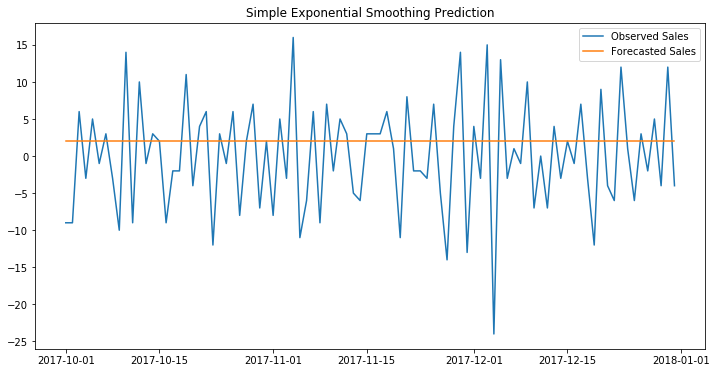

In [12]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Simple Exponential Smoothing Prediction")

In [13]:
print('Simple Exponential Smoothing MAE = ', mean_absolute_error(predictions, test))

Simple Exponential Smoothing MAE =  6.163043478260869


#### Implementing Using Statsmodel

In [18]:
ses = SimpleExpSmoothing(train)

alpha = 1.0
model = ses.fit(smoothing_level = alpha, optimized = False)

In [19]:
forecast = model.forecast(len(test))

Text(0.5, 1.0, 'Simple Exponential Smoothing Prediction')

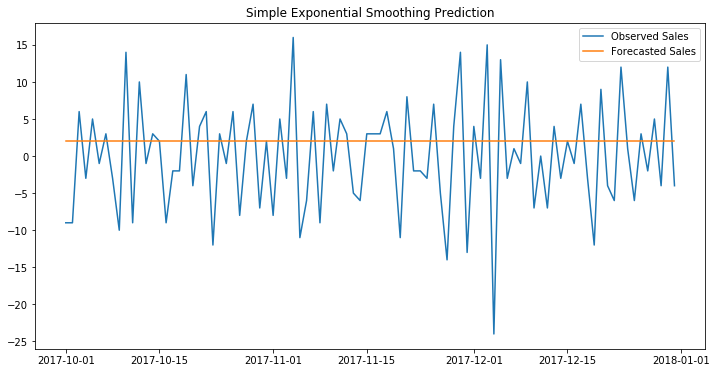

In [16]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast_val = plt.plot(forecast, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Simple Exponential Smoothing Prediction")

In [20]:
print('Simple Exponential Smoothing MAE = ', mean_absolute_error(forecast, test))

Simple Exponential Smoothing MAE =  6.163043478260869


### Limitations of Simple Exponential Smoothing

* Simple Exponential Smoothing is unable to project trends.
* Simple Exponential Smoothing is unable to recognize any seasonal pattern
* Underfitting

## Double Exponential Smoothing

* Double Exponential Smoothing is an extended form of Simple Exponential Smoothing as it includes a trend component in its estimation.
* Double Exponential Smoothing has two smoothing equations. One to estimate the level, the other to estimate the trend
* Double Exponential Smoothing will estimate the trend based on an exponential weight $\beta$. More or less importance will be given to most recent observations.

### Equation

The forecast is computed using two equations: Level and Trend

$$Forecast = Level + Trend$$
$$f_{t+1} = a_t + b_t$$

#### Level Estimation

This component of the forecast equation is used to estimate the level of the time-series.

$$a_t = \alpha d_t + (1-\alpha)(a_{t-1} + b_{t-1})$$

This equation is very similar to the equation for Simple Exponential Smoothing. The model will update $a_t$ at each period using the previous demand value. The previous level estimation ($a_{t-1}$) is increased by the previous trend estimation ($b_{t-1}$)

$\alpha$ is the importance given to the most recent demand history. The values of $\alpha$ range from 0 to 1.

#### Trend Estimation

This component of the forecast equation is used to estimate the trend of the time-series.

$$b_t = \beta(a_t - a_{t-1}) + (1-\beta)b_{t-1}$$

$\beta$ is the learning parameter for the trend. The values of $\beta$ range from 0 to 1.

#### Full Forecast Equation

The full model used to generate forecasts of period t + $\lambda$:

$$a_t = \alpha d_t + (1-\alpha)(a_{t-1} + b_{t-1})$$
$$b_t = \beta(a_t - a_{t-1}) + (1-\beta)b_{t-1}$$
$$f_{t+\lambda} = a_t + \lambda b_t$$

### Implementing Double Exponential Smoothing Model

In [21]:
def double_exponential_smoothing(d, extra_periods, alpha, beta):
    

    # Historical period length
    cols = len(d)
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods)

    # Creation of the level, trend and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan)

    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]

    # Create all the t+1 forecast
    for t in range(1,cols):
        f[t] = a[t-1] + b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*b[t-1]

    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + b[t-1]
        a[t] = f[t]
        b[t] = b[t-1]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a, 
        'Trend':b, 'Error':d-f})

    return df

In [22]:
double_results = double_exponential_smoothing(train, len(test), 1.0, 1.0)

In [23]:
double_results

,Demand,Forecast,Level,Trend,Error
0,-2.0,NaN,-2.0,5.0,NaN
1,3.0,3.0,3.0,5.0,0.0
2,-1.0,8.0,-1.0,-4.0,-9.0
3,-3.0,-5.0,-3.0,-2.0,2.0
4,2.0,-5.0,2.0,5.0,7.0
...,...,...,...,...,...
1820,NaN,-262.0,-262.0,-3.0,NaN
1821,NaN,-265.0,-265.0,-3.0,NaN
1822,NaN,-268.0,-268.0,-3.0,NaN
1823,NaN,-271.0,-271.0,-3.0,NaN


In [24]:
double_predictions = double_results[-len(test):]['Forecast']

In [25]:
double_predictions = double_predictions.set_axis(index_values)

Text(0.5, 1.0, 'Double Exponential Smoothing Prediction')

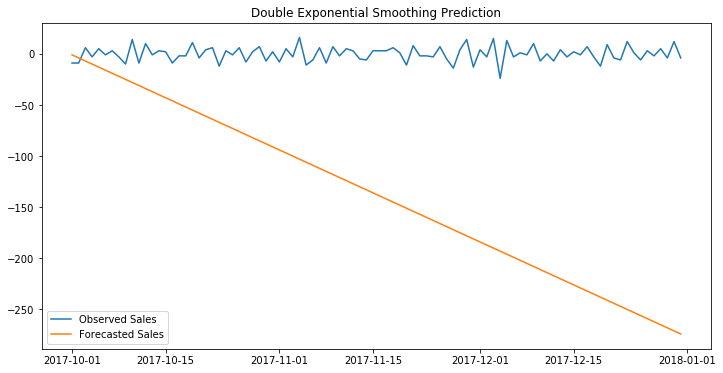

In [26]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(double_predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Double Exponential Smoothing Prediction")

#### Limitations

* Double Exponential Smoothing assumes that the trend is ever going. This can be see by the above plot as the forecasted sales keeps decreasing because that was the last trend it observed.
* This can be problematic for mid- and long-term forecasts.
* Double Exponential Smoothing model is unable to recognize seasonality.
* Can't take external information

## Double Exponential Smoothing with Damped Trend

* Double Exponential Smoothing with Damped Trend is basically the same model with an added factor $\phi$
* This $\phi$ factor exponentially reduces the trend over time.
* The trend $b$ will be reduced by a factor of $\phi$ in each period.
* In theory, $\phi$ can be between 0 and 1, however for practical use it will be between 0.7 and 1. This is because:
    * $\phi = 0$ is basically the same thing as having Simple Exponential Model
    * $\phi = 1$ is basically the same thing as having Double Exponential Model

### Equation

Double Exponential Smoothing with Damped Trend is implemented by multiplying all instances of $b_{t-1}$ by $\phi$

$$a_t = \alpha d_t + (1-\alpha)(\alpha_{t-1} + \phi b_{t-1})$$
$$b_t = \beta(a_t - a_{t-1}) + (1-\beta)\phi b_{t-1}$$

The forecast for the next period would be
$$f_{t+1} = a_t + b_t \phi$$

A more general equation for forecast made on period t for period t $+ \lambda$

$$f_{t+\lambda} = a_t + b_t \sum_{i=1}^\lambda \phi^i$$

### Implementing Double Exponential Smoothing Model with Damped Trend

In [29]:
def double_exponential_smooth_damped(d, extra_periods, alpha, beta, phi):

    # Historical period length
    cols = len(d) 
    # Append np.nan into the demand array to cover future periods
    d = np.append(d,[np.nan]*extra_periods) 

    # Creation of the level, trend, and forecast arrays
    f,a,b = np.full((3,cols+extra_periods),np.nan)

    # Level & Trend initialization
    a[0] = d[0]
    b[0] = d[1] - d[0]
    
    # Create all the t+1 forecast
    for t in range(1,cols):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = alpha*d[t] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]

    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + phi*b[t-1]
        a[t] = f[t]
        b[t] = phi*b[t-1]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a,'Trend':b, 'Error':d-f})

    return df

In [30]:
double_damp_results = double_exponential_smooth_damped(train, len(test), 1.0, 1.0, 0.9)

In [31]:
double_damp_results

,Demand,Forecast,Level,Trend,Error
0,-2.0,NaN,-2.000000,5.000000,NaN
1,3.0,2.500000,3.000000,5.000000,0.5
2,-1.0,7.500000,-1.000000,-4.000000,-8.5
3,-3.0,-4.600000,-3.000000,-2.000000,1.6
4,2.0,-4.800000,2.000000,5.000000,6.8
...,...,...,...,...,...
1820,NaN,-24.997461,-24.997461,-0.000282,NaN
1821,NaN,-24.997715,-24.997715,-0.000254,NaN
1822,NaN,-24.997943,-24.997943,-0.000229,NaN
1823,NaN,-24.998149,-24.998149,-0.000206,NaN


In [32]:
double_damp_predictions = double_damp_results[-len(test):]['Forecast']

In [33]:
double_damp_predictions = double_damp_predictions.set_axis(index_values)

Text(0.5, 1.0, 'Double Exponential Smoothing with Damped Trend Prediction')

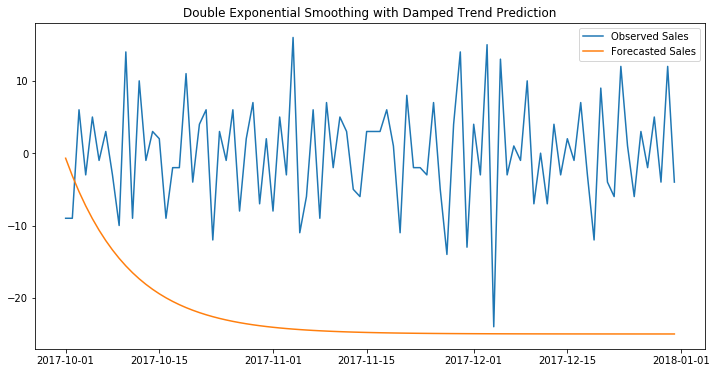

In [34]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(double_damp_predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Double Exponential Smoothing with Damped Trend Prediction")

As seen from the above figure, the damp factor forgets the trend as overtime the forecasted sales line becomes horizontal reaching a stable level.

#### Limitations

* Double Exponential Smoothing with Damped Trend is unable to recognize any seasonal pattern

## Triple Exponential Smoothing

In supply chains, there are seasonal products. These products have high or low seasons depending on the different factors affecting seasonality.

The previous models we've been introduced to are unable to identify seasonality. In order to do so we must add a third layer of exponential smoothing.

The idea is that the model will learn multiplicative seasonal factors that will be applied to each period inside a full seasonal cycle.

The seasonal factors will be learned through a new learning rate $(\gamma)$

### Equation

The forecast equation now consists of the level, trend, and damping componenet all multiplied by the seasonal factor (s).

$$Forecast = (Level + Trend) Season$$
$$f_{t+1} = (a_t + \phi b_t)s_{t+1-p}$$

The different components of our forecast equation are calculated as follows:

$$a_t = \alpha \frac{d_t}{s_{t-p}} + (1-\alpha)(a_{t-1} + \phi b_{t-1})$$

$$b_t = \beta (a_t - a_{t-1}) + (1-\beta)\phi b_{t-1}$$

$$s_t = \gamma \frac{d_t}{a_t} + (1-\gamma)s_{t-p}$$

We are using the seasonal factor that was calculated last season (p) is the season length.

The Level and Trend are deseasonalized.

Similar to $\alpha$ and $\beta$, $\gamma$ is theoretically between 0 and 1, however in practice it should be low (<0.3). This is because business-wise it is rare that the seasonality could change by a lot from one year to another.

### Implementing Triple Exponential Smoothing Model 

In [35]:
# This function is used to compute the multiplicative seasonal factors.

def seasonal_factors_mul(s,d,slen,cols):
    for i in range(slen):
        # Season average
        s[i] = np.mean(d[i:cols:slen])
        # scale all season factors (sum of factors = slen)
    s /= np.mean(s[:slen])
    return s

In [44]:
def triple_exp_smooth_mul(d, slen, extra_periods, alpha,beta, phi, gamma):

    cols = len(d) # Historical pteriod length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    # components initialization
    f,a,b,s = np.full((4,cols+extra_periods),np.nan)
    s = seasonal_factors_mul(s,d,slen,cols)

    # Level & Trend initialization
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1] - d[0]/s[0]

    # Create the forecast for the first season
    for t in range(1,slen):
        f[t] = (a[t-1] + phi*b[t-1])*s[t]
        a[t] = alpha*d[t]/s[t] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]

    # Create all the t+1 forecast
    for t in range(slen,cols):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = alpha*d[t]/s[t-slen] + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*d[t]/a[t] + (1-gamma)*s[t-slen]

    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = (a[t-1] + phi*b[t-1])*s[t-slen]
        a[t] = f[t]/s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a,'Trend':b, 'Season':s,'Error':d-f})

    return df

In [48]:
triple_results = triple_exp_smooth_mul(train, 365, len(test), 1.0, 1.0, 0.9, 0.2)

In [49]:
triple_results

,Demand,Forecast,Level,Trend,Season,Error
0,-2.0,NaN,-0.008733,-0.004366,229.019608,NaN
1,3.0,2.9000,-0.013099,-0.004366,-229.019608,0.1000
2,-1.0,-0.4875,-0.034932,-0.021832,28.627451,-0.5125
3,-3.0,-0.0000,-inf,-inf,0.000000,-3.0000
4,2.0,inf,NaN,NaN,-114.509804,-inf
...,...,...,...,...,...,...
1820,NaN,NaN,NaN,NaN,NaN,NaN
1821,NaN,NaN,NaN,NaN,NaN,NaN
1822,NaN,NaN,NaN,NaN,NaN,NaN
1823,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
triple_predictions = triple_results[-len(test):]['Forecast']

In [41]:
triple_predictions = triple_predictions.set_axis(index_values)

Text(0.5, 1.0, 'Triple Exponential Smoothing Prediction')

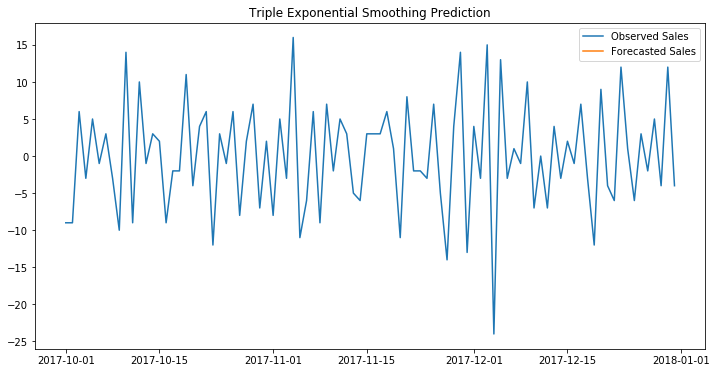

In [42]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(triple_predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Triple Exponential Smoothing Prediction")

#### Limitations

The Triple Exponential Smoothing model enables us to deal with seasonality. 

However the mulitiplicative part of the model might result in erros if the demand level or the seasonality factors are too close to 0. Therefore this model is not suited for all products.

## Triple Additive Exponential Smoothing

The issue with the previous model is that it reacts poorly when there are periods with very low volumes.

With this model, we are replacing the multiplicative seasonality with an additive one.

With multiplicative seasonality, we interpret the seasonal factors as a percentage increase. For example we saw 20% more products were sold in February compared to January.

With additive seasonality, we interpret the seasonal factors as an absolute amount. For example we saw 120 more products were sold in February compared to January.

### Equation

The forecast equation is very similar to the previous one we implement, however this time the seasonality is being added instead of multiplied.

$$Forecast = Level + Trend + Season$$
$$f_{t+1} = a_t + \phi b_t + s_{t+1-p}$$

We are using the seasonal factor that was calculated last season (p) is the season length.

The seasonality factors can now be read as an amount to add/substract from the period level to obtain the forecast.

The Level and Trend are deseasonalized.

For example, if $s_{january} = 20$, it means you will sell 20 more pices in January than in an average month.

Similar to $\alpha$ and $\beta$, $\gamma$ is theoretically between 0 and 1, however in practice it should be low (<0.3). This is because business-wise it is rare that the seasonality could change by a lot from one year to another. For additive, slightly higher than multiplicative.

### Implementing Triple Additive Exponential Smoothing Model 

In [50]:
def seasonal_factors_add(s, d, slen, cols):
    for i in range(slen):
        # calculate season average
        s[i] = np.mean(d[i:cols:slen])
    # scale all season factors 
    s -= np.mean(s[:slen])
    return s

In [51]:
def triple_exp_smooth_add(d, slen, extra_periods, alpha, beta, phi, gamma):

    cols = len(d) # Historical pteriod length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    # components initialization
    f,a,b,s = np.full((4,cols+extra_periods),np.nan)
    s = seasonal_factors_add(s,d,slen,cols)

    # Level & Trend initialization
    a[0] = d[0]-s[0]
    b[0] = (d[1]-s[1]) - (d[0]-s[0])

    # Create the forecast for the first season
    for t in range(1,slen):
        f[t] = a[t-1] + phi*b[t-1] + s[t]
        a[t] = alpha*(d[t]-s[t]) + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]

    # Create all the t+1 forecast
    for t in range(slen,cols):
        f[t] = a[t-1] + phi*b[t-1] + s[t-slen]
        a[t] = alpha*(d[t]-s[t-slen]) + (1-alpha)*(a[t-1]+phi*b[t-1])
        b[t] = beta*(a[t]-a[t-1]) + (1-beta)*phi*b[t-1]
        s[t] = gamma*(d[t]-a[t]) + (1-gamma)*s[t-slen]

    # Forecast for all extra periods
    for t in range(cols,cols+extra_periods):
        f[t] = a[t-1] + phi*b[t-1] + s[t-slen]
        a[t] = f[t]-s[t-slen]
        b[t] = phi*b[t-1]
        s[t] = s[t-slen]

    df = pd.DataFrame.from_dict({'Demand':d,'Forecast':f,'Level':a,'Trend':b, 'Season':s,'Error':d-f})

    return df

In [62]:
triple_add_results = triple_exp_smooth_add(train, 500, len(test), 1.0, 1.0, 0.9, 0.2)

In [63]:
triple_add_results

,Demand,Forecast,Level,Trend,Season,Error
0,-2.0,NaN,-1.243667,-5.000000e-01,-0.756333,NaN
1,3.0,3.050000,-1.743667,-5.000000e-01,4.743667,-0.050
2,-1.0,-5.700000,2.506333,4.250000e+00,-3.506333,4.700
3,-3.0,3.075000,0.256333,-2.250000e+00,-3.256333,-6.075
4,2.0,-0.025000,0.256333,-2.220446e-16,1.743667,2.025
...,...,...,...,...,...,...
1820,NaN,-0.583122,-2.243455,-2.351153e-05,1.660333,NaN
1821,NaN,-3.583143,-2.243476,-2.116037e-05,-1.339667,NaN
1822,NaN,-5.916495,-2.243495,-1.904434e-05,-3.673000,NaN
1823,NaN,-1.249846,-2.243512,-1.713990e-05,0.993667,NaN


In [64]:
triple_add_predictions = triple_add_results[-len(test):]['Forecast']

In [65]:
triple_add_predictions = triple_add_predictions.set_axis(index_values)

Text(0.5, 1.0, 'Triple Additive Exponential Smoothing Prediction')

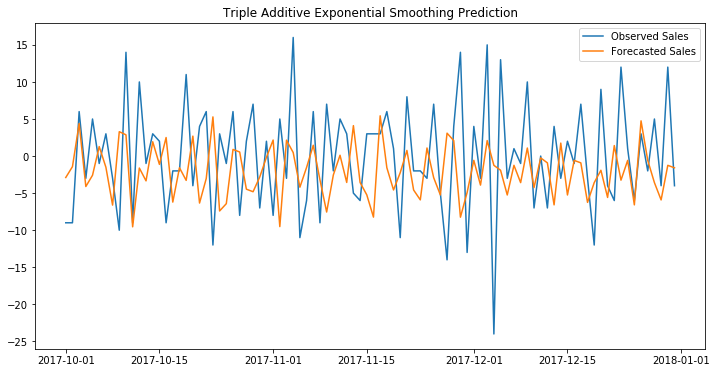

In [66]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(test, label = 'Observed Sales')
forecast = plt.plot(triple_add_predictions, label = 'Forecasted Sales')
plt.legend(loc = 'best')
plt.title("Triple Additive Exponential Smoothing Prediction")

#### Limitations

* Just like the other Exponential Smoothing model, this model is unable to use external variables which could be very useful.